# Predicting the Severity of LBP

In [1]:
# importing relevant packages
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost
from xgboost import XGBClassifier


## 1. Data Wrangling

In [2]:
#Load data
df=pd.read_csv('/Users/nirathikeerthi/Desktop/Springboard/Capstone 3 - LBP/LBP_data.csv')

In [3]:
# Data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Participant No.        60 non-null     int64  
 1   Gender                 60 non-null     object 
 2   Age                    60 non-null     int64  
 3   Height                 60 non-null     int64  
 4   Weight                 60 non-null     int64  
 5   BMI                    60 non-null     float64
 6   Ethnicity              60 non-null     object 
 7   History                60 non-null     object 
 8   Physical activity      60 non-null     int64  
 9   Alcohol                60 non-null     int64  
 10  Smoking                60 non-null     int64  
 11  Hours/day              60 non-null     object 
 12  Years                  54 non-null     float64
 13  Occ. Score             60 non-null     int64  
 14  Posture                60 non-null     int64  
 15  Force   

In [4]:
df.drop(columns='Participant No.', inplace=True)

In [5]:
# No. of rows and columns
df.shape

(60, 28)

In [6]:
#visualize
df.head()

,Gender,Age,Height,Weight,BMI,Ethnicity,History,Physical activity,Alcohol,Smoking,...,JCQ Score,Decision Latitude,Physical Demands,Psychological Demands,Social Support,Organizational Level,Job Satisfaction,Job Security,ODI Score,VAS
0,F,37,62,162,29.626951,Caucasian,Yes,1,1,1,...,162.000000,78,5,8,38,34,0.000000,-1,30,10.00
1,M,72,64,184,31.580078,Caucasian,Yes,4,2,3,...,183.100000,70,10,8,31,61,0.100000,3,70,10.00
2,F,56,65,168,27.953609,Caucasian,No,1,2,3,...,152.566667,66,16,6,33,30,0.566667,1,94,9.84
3,F,60,65,218,36.273136,Black,No,6,3,4,...,172.566667,72,19,16,30,29,0.566667,6,44,8.27
4,M,38,72,209,28.342400,Caucasian,No,1,3,1,...,145.000000,74,10,2,30,28,0.000000,1,40,7.01


In [7]:
#Checking for null values
df.isnull().sum()

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    6
Occ. Score               0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS Score                0
JCQ Score                0
Decision Latitude        0
Physical Demands         0
Psychological Demands    0
Social Support           0
Organizational Level     0
Job Satisfaction         1
Job Security             0
ODI Score                0
VAS                      0
dtype: int64

In [8]:
#Checking for missing values
df.isin(['?']).sum(axis=0)

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    0
Occ. Score               0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS Score                0
JCQ Score                0
Decision Latitude        0
Physical Demands         0
Psychological Demands    0
Social Support           0
Organizational Level     0
Job Satisfaction         0
Job Security             0
ODI Score                0
VAS                      0
dtype: int64

In [9]:
# Calculate average ODI and VAS by History and sort by the average of the two
history_means = df.groupby('History')[['ODI Score', 'VAS']].mean()
history_means.head()

,ODI Score,VAS
History,,
No,38.750000,8.095417
Yes,43.222222,7.738333


In [10]:
# Calculate average ODI and VAS by Gender and sort by the average of the two
gender_means = df.groupby('Gender')[['ODI Score', 'VAS']].mean()
gender_means.head()

,ODI Score,VAS
Gender,,
F,41.352941,7.929706
M,41.538462,7.817692


In [11]:
# Calculate average ODI and VAS by Ethnicity and sort by the average of the two
ethnicity_means = df.groupby('Ethnicity')[['ODI Score', 'VAS']].mean()
ethnicity_means.head()

,ODI Score,VAS
Ethnicity,,
Black,43.444444,7.134444
Caucasian,41.641026,8.157179
Hispanic,30.000000,10.000000
Other,24.000000,6.560000
Other/Jewish,26.000000,9.760000


In [12]:
df['Ethnicity'].value_counts()

Caucasian       39
Black           18
Hispanic         1
Other/Jewish     1
Other            1
Name: Ethnicity, dtype: int64

In [13]:
# Calculate average ODI and VAS by Hours/day and sort by the average of the two
hours_means = df.groupby('Hours/day')[['ODI Score', 'VAS']].mean()
hours_means.head()

,ODI Score,VAS
Hours/day,,
10,34.4,8.322
10 to 12,20.0,7.730
10.5,38.0,4.250
10/week,48.0,8.130
11,16.0,8.280


In [41]:
df['Hours/day'].value_counts()

8           21
8 to 10      5
10           5
5            4
6            3
8 to 12      3
9            2
12           2
4            2
8 to 9       2
11           1
8 to 16      1
>8           1
4 to 12      1
7            1
10.5         1
10/week      1
10 to 12     1
>8           1
4 to 6       1
5 to 8       1
Name: Hours/day, dtype: int64

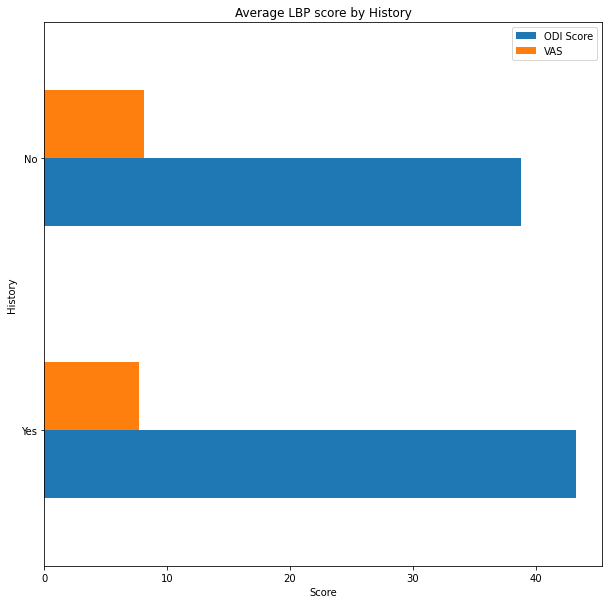

In [15]:
(history_means.reindex(index=history_means.mean(axis=1)
    .sort_values(ascending=False)
    .index)
    .plot(kind='barh', figsize=(10, 10), title='Average LBP score by History'))
plt.xlabel('Score');

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,60.0,47.083333,16.172053,20.000000,33.000000,48.000000,57.25000,83.000000
Height,60.0,67.033333,3.875025,59.000000,64.000000,66.000000,70.00000,75.000000
Weight,60.0,184.533333,37.726252,95.000000,160.000000,180.000000,211.25000,275.000000
BMI,60.0,28.859479,5.348535,16.826657,25.807846,28.233276,31.65558,42.126754
Physical activity,60.0,2.533333,1.599435,1.000000,1.000000,3.000000,4.00000,6.000000
Alcohol,60.0,1.750000,0.772954,1.000000,1.000000,2.000000,2.00000,3.000000
Smoking,60.0,1.600000,1.028410,1.000000,1.000000,1.000000,2.00000,5.000000
Years,54.0,12.722222,10.901647,1.000000,4.000000,10.000000,20.00000,50.000000
Occ. Score,60.0,12.283333,6.279079,3.000000,6.000000,12.000000,17.25000,27.000000
Posture,60.0,6.300000,1.985541,3.000000,5.000000,6.000000,8.00000,10.000000


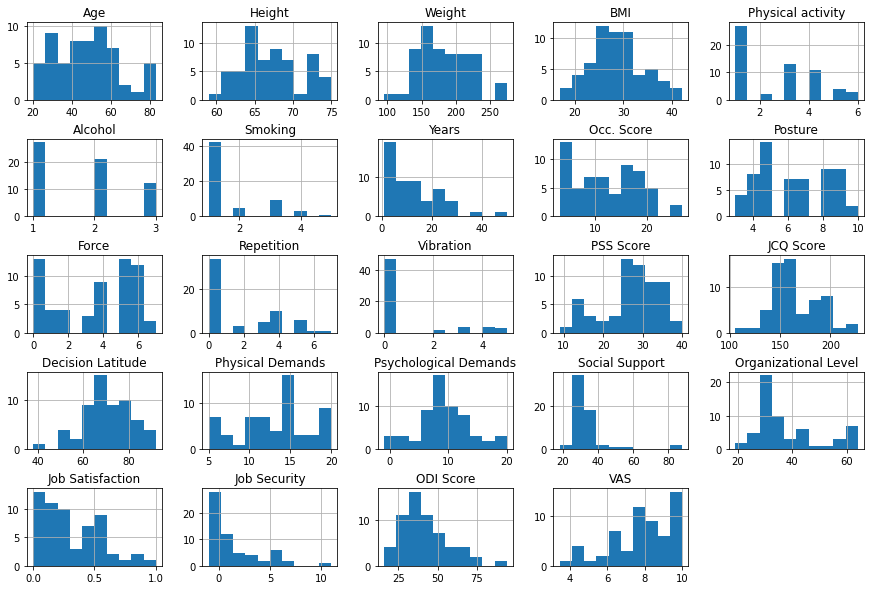

In [17]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [18]:
df['Years'].value_counts()

1.0     5
2.0     5
10.0    4
4.0     4
3.0     3
22.0    3
15.0    3
30.0    3
20.0    3
11.0    2
25.0    2
13.0    2
5.0     2
12.0    2
7.0     2
9.0     1
21.0    1
26.0    1
40.0    1
24.0    1
16.0    1
6.0     1
50.0    1
8.0     1
Name: Years, dtype: int64

In [33]:
df=df.fillna(df.median())

In [34]:
#Checking for null values
df.isnull().sum()

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    0
Occ. Score               0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS Score                0
JCQ Score                0
Decision Latitude        0
Physical Demands         0
Psychological Demands    0
Social Support           0
Organizational Level     0
Job Satisfaction         0
Job Security             0
ODI Score                0
VAS                      0
dtype: int64

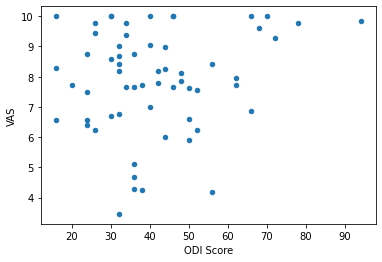

In [19]:
# Target Feature
df.plot(x='ODI Score', y='VAS', kind='scatter');

In [20]:
df['ODI Score'].value_counts()

32    6
36    5
24    4
30    4
34    3
40    3
50    3
16    3
46    3
26    3
44    3
56    2
52    2
48    2
42    2
66    2
38    2
62    2
68    1
94    1
20    1
78    1
72    1
70    1
Name: ODI Score, dtype: int64

In [21]:
df['VAS'].value_counts()

10.00    8
9.76     3
7.66     3
6.56     2
7.72     2
8.43     2
4.17     1
7.48     1
7.56     1
9.45     1
6.61     1
8.67     1
5.12     1
6.25     1
9.29     1
6.85     1
7.64     1
4.69     1
7.01     1
7.97     1
8.75     1
7.79     1
4.30     1
8.98     1
9.00     1
6.69     1
6.02     1
3.46     1
6.77     1
9.06     1
7.73     1
8.19     1
6.22     1
8.13     1
8.28     1
8.74     1
8.59     1
8.20     1
5.91     1
9.61     1
4.25     1
8.27     1
7.87     1
9.37     1
6.41     1
9.84     1
Name: VAS, dtype: int64

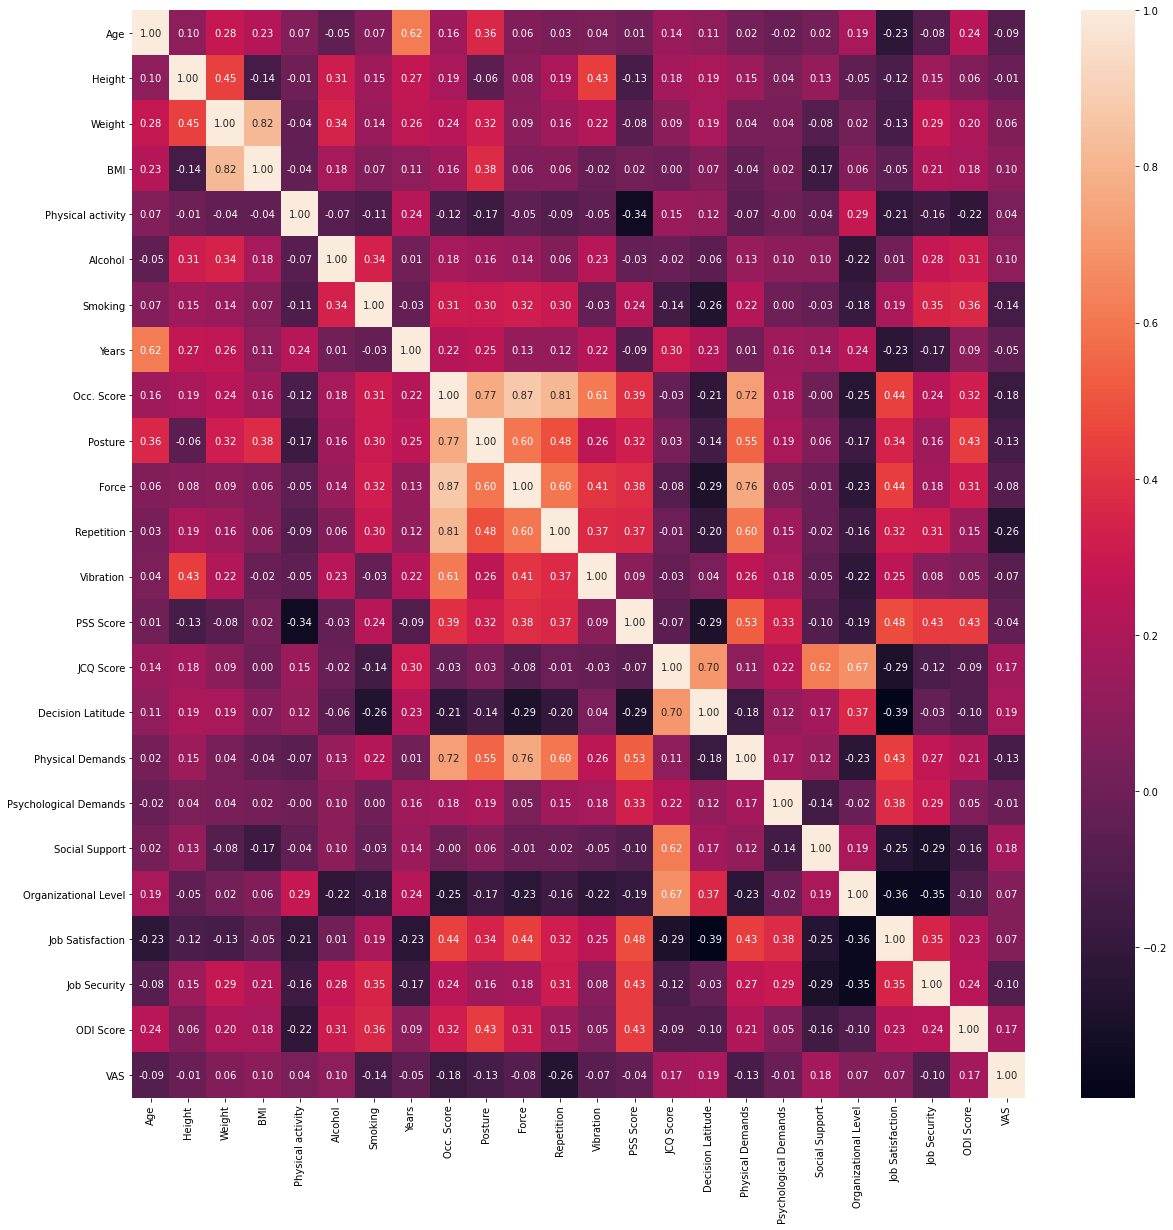

In [23]:
#Visualize correlation of the target variable with other features
plt.subplots(figsize=(20,20))

corr = df.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

## 2. EDA

In [24]:
#Scatter Plots
# define useful function to create scatterplots against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'ODI Score', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='ODI Score')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [25]:
features = [column for column in df.columns if column not in ['Gender', 'History', 'Ethnicity', 'Hours/day', 'VAS', 'ODI Score']]

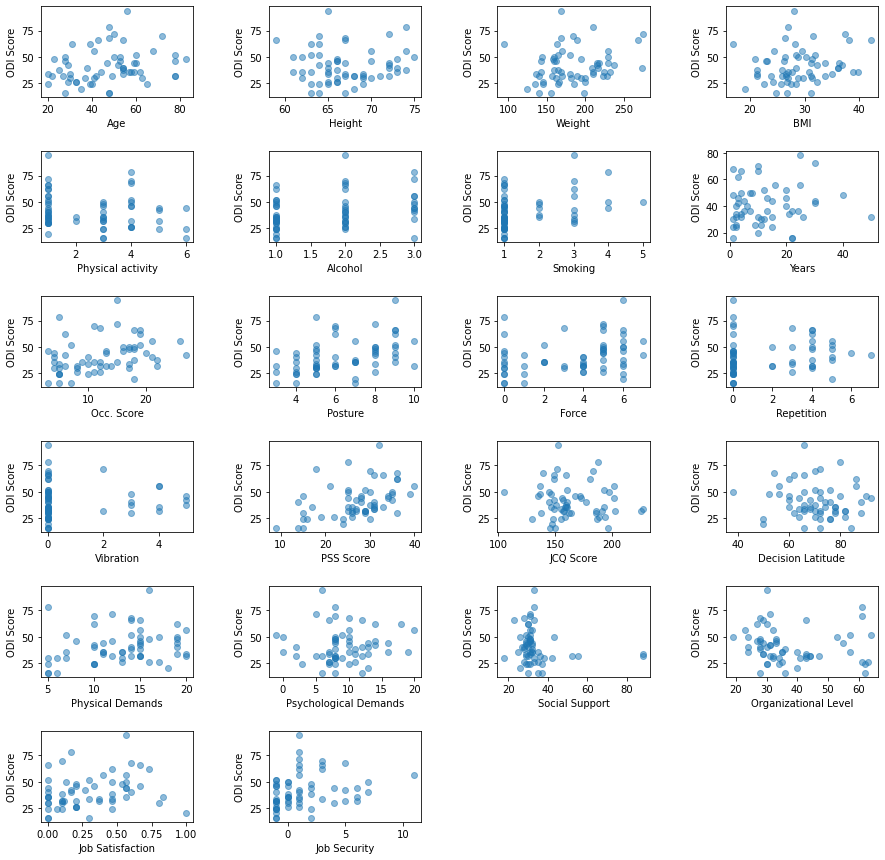

In [26]:
scatterplots(features, ncol=4, figsize=(15, 15))

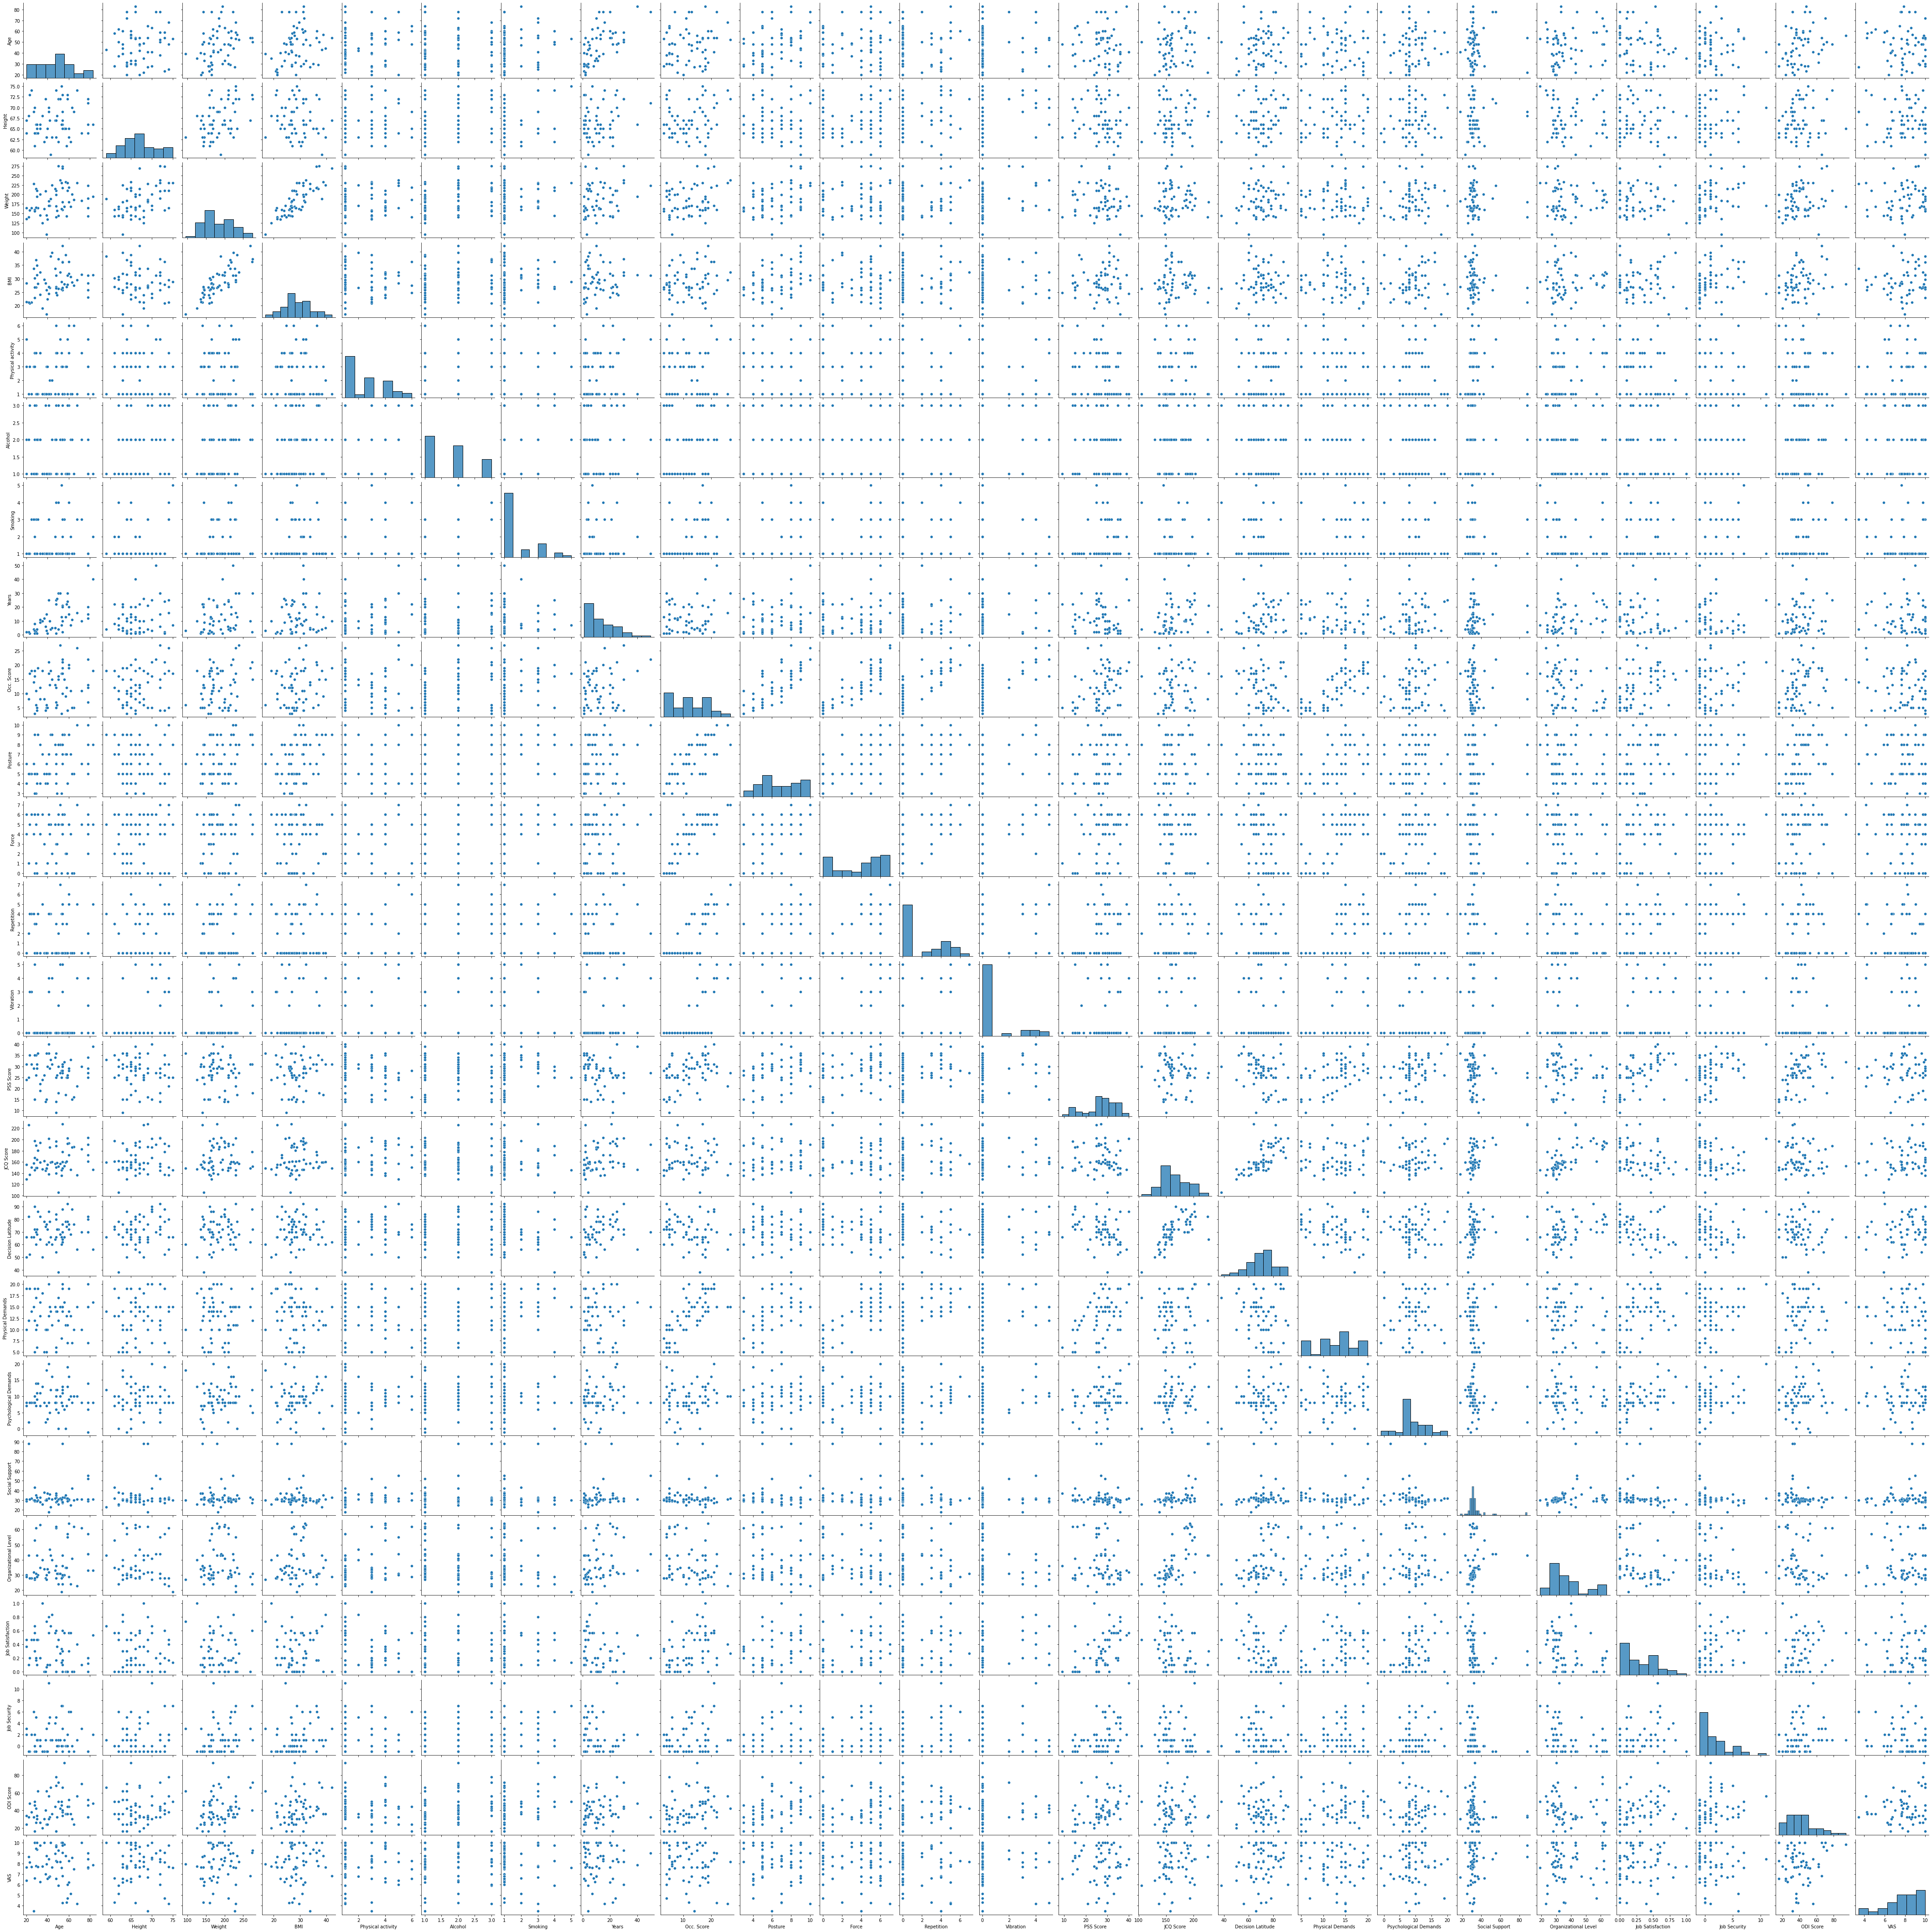

In [27]:
# Make a pairplot of the data
sns.pairplot(df)

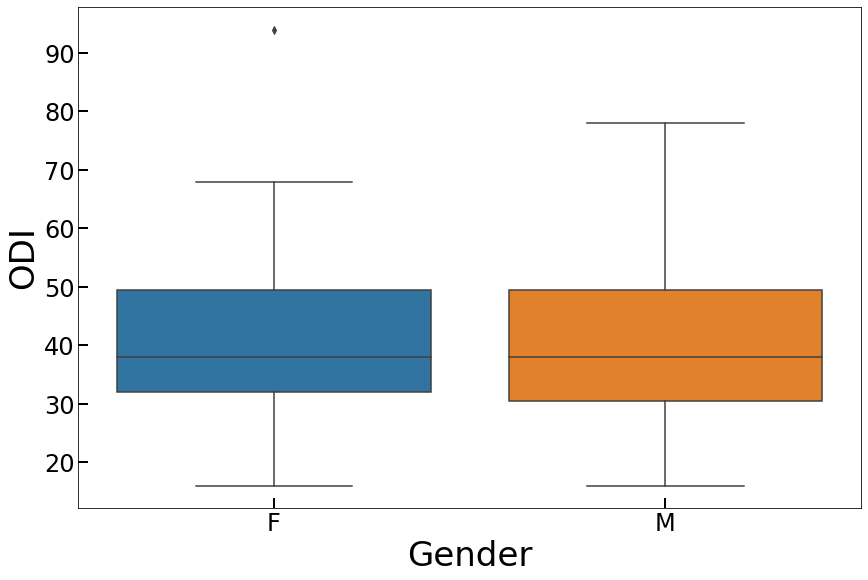

Median value Gender
F    38
M    38
Name: ODI Score, dtype: int64


In [29]:
# Use the boxplot() method to see if Gender has any effect on ODI
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Gender', y='ODI Score',data=df)
plt.xlabel('Gender',fontsize=34)
plt.ylabel('ODI',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('Gender')['ODI Score'].median()
print("Median value", Gender_median)


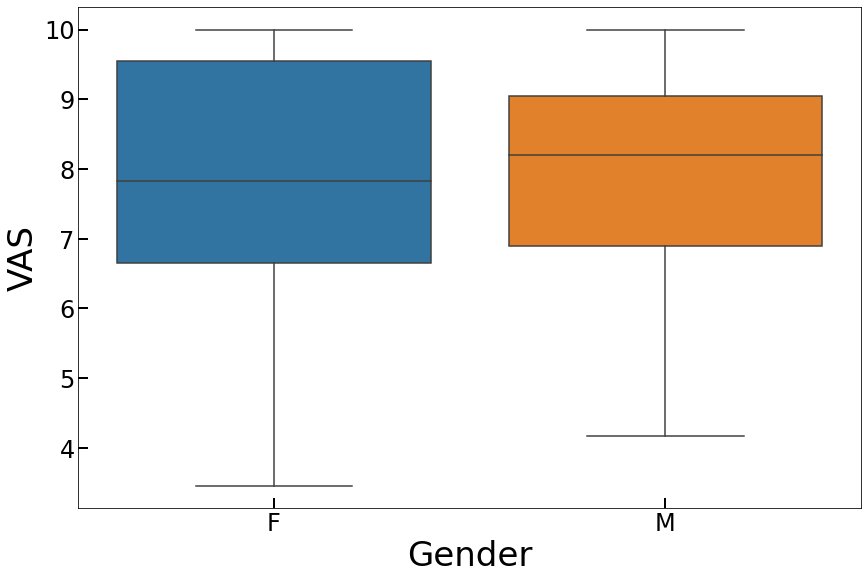

Median value Gender
F    7.830
M    8.195
Name: VAS, dtype: float64


In [30]:
# Use the boxplot() method to see if Gender has any effect on VAS
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Gender', y='VAS',data=df)
plt.xlabel('Gender',fontsize=34)
plt.ylabel('VAS',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('Gender')['VAS'].median()
print("Median value", Gender_median)

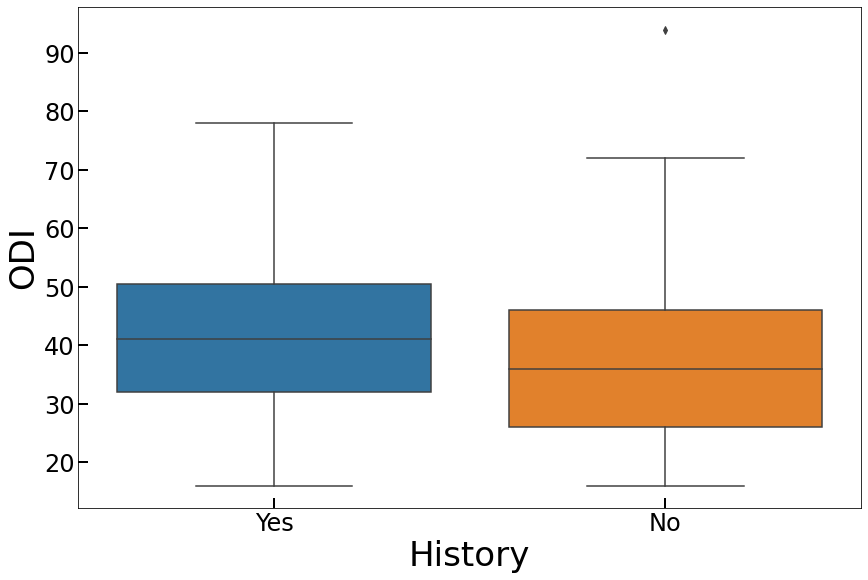

Median value History
No     36
Yes    41
Name: ODI Score, dtype: int64


In [35]:
# Use the boxplot() method to see if Family history has any effect on ODI
plt.subplots(figsize=(12, 8))
sns.boxplot(x='History', y='ODI Score',data=df)
plt.xlabel('History',fontsize=34)
plt.ylabel('ODI',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('History')['ODI Score'].median()
print("Median value", Gender_median)

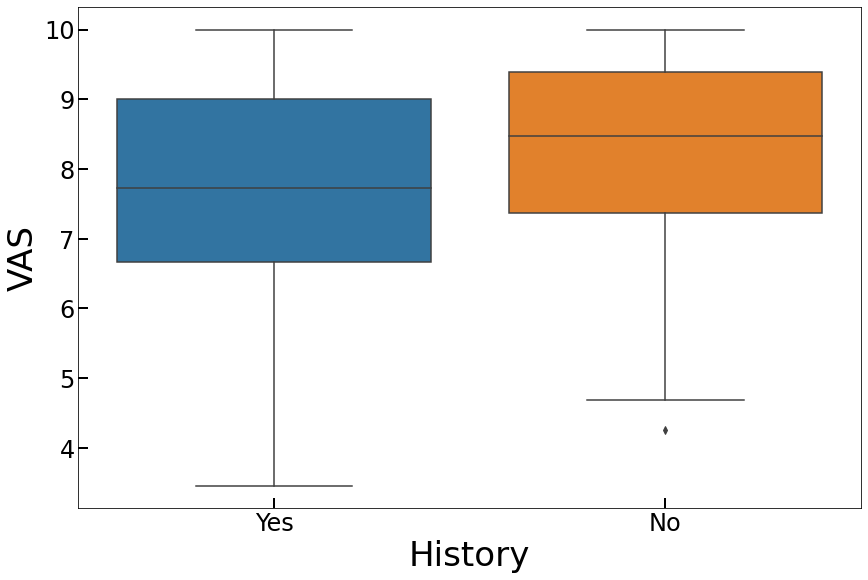

Median value History
No     8.475
Yes    7.725
Name: VAS, dtype: float64


In [36]:
# Use the boxplot() method to see if Family history has any effect on VAS
plt.subplots(figsize=(12, 8))
sns.boxplot(x='History', y='VAS',data=df)
plt.xlabel('History',fontsize=34)
plt.ylabel('VAS',fontsize=34)
plt.tick_params(which='major', length=10,labelsize=24,width=2,direction='in')
plt.tight_layout(pad=0.5)
plt.show()

Gender_median=df.groupby('History')['VAS'].median()
print("Median value", Gender_median)

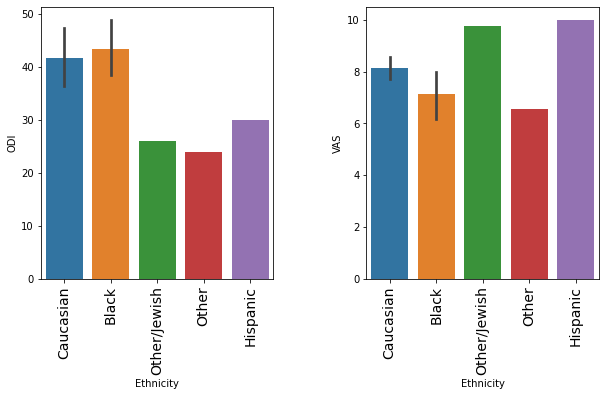

In [37]:
# Check Ethnicity
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
g1=sns.barplot(x="Ethnicity", y="ODI Score", data=df,ax=ax[0])
g1.set_xticklabels(g1.get_xticklabels(), rotation=90,size=14)
g1.set(ylabel='ODI')
#g1.set(xlabel=None)
g2=sns.barplot(x="Ethnicity", y="VAS", data=df,ax=ax[1])
g2.set_xticklabels (g2.get_xticklabels(), rotation=90,size=14)
g2.set(ylabel='VAS')
plt.subplots_adjust(wspace=0.4)

plt.show()

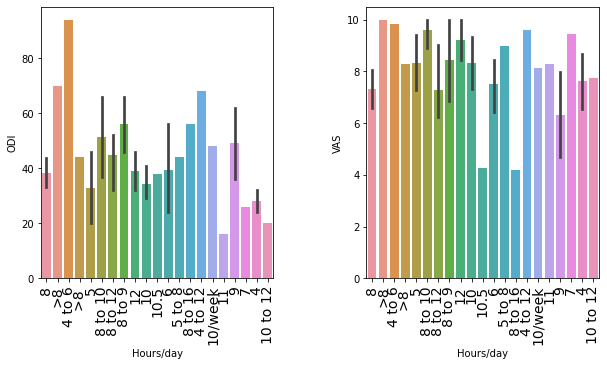

In [38]:
# Check Hours/day
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
g1=sns.barplot(x="Hours/day", y="ODI Score", data=df,ax=ax[0])
g1.set_xticklabels(g1.get_xticklabels(), rotation=90,size=14)
g1.set(ylabel='ODI')
#g1.set(xlabel=None)
g2=sns.barplot(x="Hours/day", y="VAS", data=df,ax=ax[1])
g2.set_xticklabels (g2.get_xticklabels(), rotation=90,size=14)
g2.set(ylabel='VAS')
plt.subplots_adjust(wspace=0.4)

plt.show()